## VAE 분석 - 얼굴 데이터셋

### 라이브러리 임포트

In [1]:
import os
import PIL
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as vutils

from vae_auto_encoder import VAEAutoEncoder
from image_label_dataset import ImageLabelDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 32
image_size = 128
z_dim_size = 200

data_path = '../data/celeba/'
csv_data_path = '../data/celeba/list_attr_celeba.csv'
model_save_path = './vae_faces_model.pth'
image_save_folder = './images/vae_celeba'

### 데이터 적재

In [4]:
att = pd.read_csv(csv_data_path)
att.head()

/home/kjh/anaconda3/envs/gan_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


202599       Unnamed: 1  Unnamed: 2       Unnamed: 3 Unnamed: 4  \
0  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes       Bald   
1        000001.jpg               -1           1                1         -1   
2        000002.jpg               -1          -1               -1          1   
3        000003.jpg               -1          -1               -1         -1   
4        000004.jpg               -1          -1                1         -1   

  Unnamed: 5 Unnamed: 6 Unnamed: 7  Unnamed: 8  Unnamed: 9  ... Unnamed: 31  \
0      Bangs   Big_Lips   Big_Nose  Black_Hair  Blond_Hair  ...     Smiling   
1         -1         -1         -1          -1          -1  ...          -1   
2         -1         -1         -1           1          -1  ...          -1   
3         -1         -1          1          -1          -1  ...          -1   
4         -1         -1         -1          -1          -1  ...          -1   

     Unnamed: 32 Unnamed: 33       Unnamed: 34  Unnamed: 35       Unnamed: 36  \
0  Straight_Hair   Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick   
1              1           1                -1            1                -1   
2              1          -1                -1           -1                -1   
3             -1          -1                 1           -1                -1   
4             -1           1                -1            1                -1   

        Unnamed: 37      Unnamed: 38 Unnamed: 39 Unnamed: 40  
0  Wearing_Necklace  Wearing_Necktie       Young         NaN  
1                 1               -1          -1         1.0  
2                -1               -1          -1         1.0  
3                -1               -1          -1         1.0  
4                 1                1          -1         1.0  

[5 rows x 41 columns]

In [5]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),])

dataset = ImageLabelDataset(data_path,
                            csv_data_path,
                            transform=transform)

dataloader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True)


Found 202599 images.


### 모델 만들기

In [6]:
model = VAEAutoEncoder(4,
                       encoder_channels=[3, 32, 64, 64, 64],
                       encoder_kernel_sizes=[3, 3, 3, 3],
                       encoder_strides=[2, 2, 2, 2],
                       decoder_channels=[64, 64, 64, 32, 3],
                       decoder_kernel_sizes=[3, 3, 3, 3],
                       decoder_strides=[2, 2, 2, 2],
                       linear_sizes=[4096, z_dim_size],
                       view_size=[-1, 64, 8, 8],
                       use_batch_norm=True,
                       use_dropout=True).to(device)

model.load_state_dict(torch.load(model_save_path, map_location=device))
model.eval()

VAEAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01, inplace=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

### 얼굴 이미지 재구성

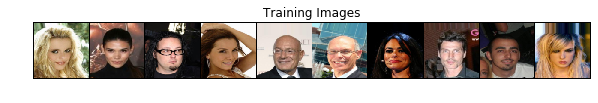

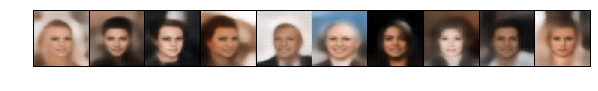

In [7]:
num_to_show = 10

inputs, _ = next(iter(dataloader))

inputs = inputs.to(device)
reconst_images, mu, log_var = model(inputs)

plt.figure(figsize=(10, 2))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(inputs[:10],
                                         nrow=10,
                                         padding=2,
                                         normalize=True).cpu(), (1, 2, 0)))
plt.savefig(os.path.join(image_save_folder, 'input_images.png'))

plt.figure(figsize=(10, 2))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(reconst_images[:10],
                                         nrow=10,
                                         padding=2,
                                         normalize=True).detach().cpu(), (1, 2, 0)))
plt.savefig(os.path.join(image_save_folder, 'output_images.png'))

### 잠재 공간 분포

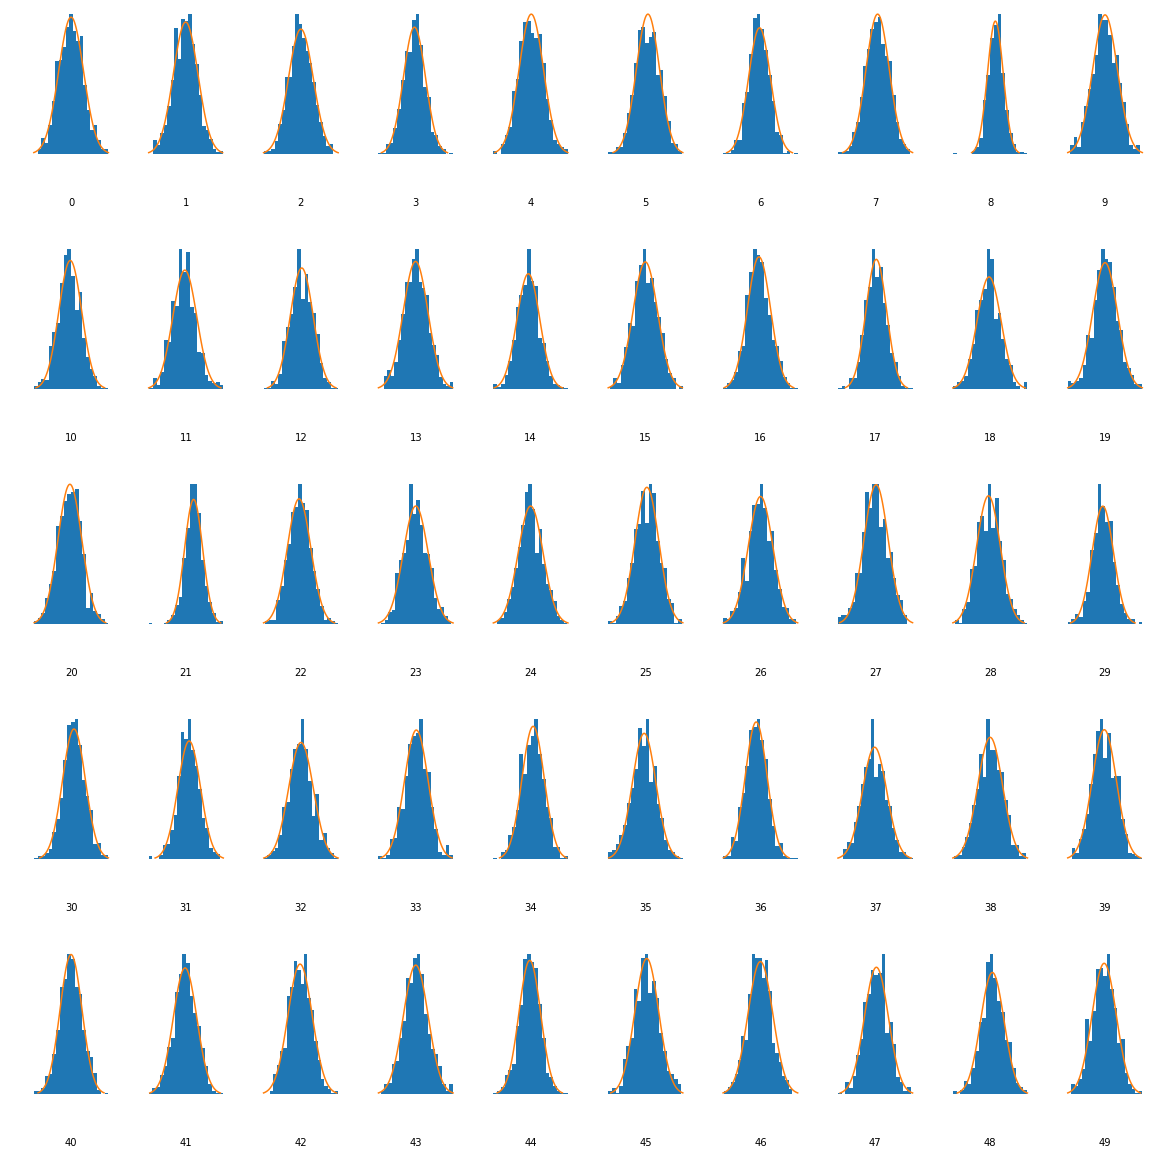

In [8]:
output_list = []

for i, (inputs, _) in enumerate(dataloader):
    inputs = inputs.to(device)
    outputs, mu, log_var = model.encode(inputs)
        
    outputs = outputs.detach().cpu().numpy()
    output_list.append(outputs)
    
    if i == 20:
        break

output_np = np.vstack(output_list)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(output_np[:, i], density=True, bins=20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x, norm.pdf(x))

fig.savefig(os.path.join(image_save_folder, 'distribution.png'))
    

### 새로 생성한 얼굴

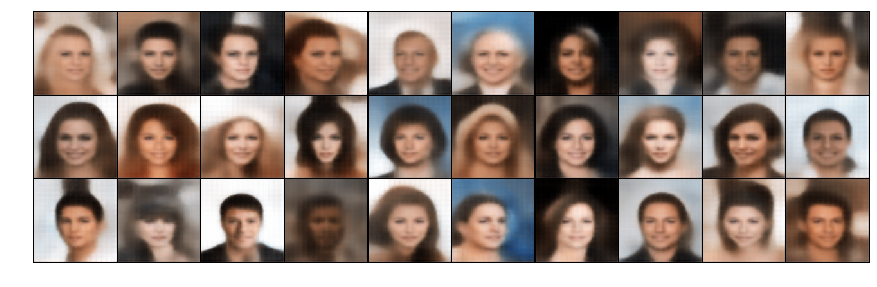

In [9]:
num_to_show = 30

z_new = torch.randn(size=(num_to_show, z_dim_size), device=device)

reconst = model.decode(z_new)
    
plt.figure(figsize=(15, 5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(reconst_images[:30],
                                         nrow=10,
                                         padding=2,
                                         normalize=True).detach().cpu(), (1, 2, 0)))
plt.savefig(os.path.join(image_save_folder, 'generated_images.png'))


In [10]:
def get_vector_from_label(label, batch_size):
    image_label_dataset = ImageLabelDataset(data_path,
                                            csv_data_path,
                                            transform=transform,
                                            label=label)

    image_label_dataloader = DataLoader(image_label_dataset,
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=4,
                                        pin_memory=True)

    origin = np.zeros(shape=z_dim_size, dtype='float32')
    current_sum_POS = np.zeros(shape=z_dim_size, dtype='float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=z_dim_size, dtype='float32')

    current_sum_NEG = np.zeros(shape=z_dim_size, dtype='float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=z_dim_size, dtype='float32')

    current_vector = np.zeros(shape=z_dim_size, dtype='float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):
        for _, (inputs, attribute) in enumerate(image_label_dataloader, 0):
            inputs = inputs.to(device)

            outputs, mu, log_var = model.encode(inputs)
            outputs = outputs.detach().cpu().numpy()

            z_POS = outputs[attribute == 1]
            z_NEG = outputs[attribute == -1]

            if len(z_POS) > 0:
                current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
                current_n_POS += len(z_POS)
                new_mean_POS = current_sum_POS / current_n_POS
                movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

            if len(z_NEG) > 0:
                current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
                current_n_NEG += len(z_NEG)
                new_mean_NEG = current_sum_NEG / current_n_NEG
                movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

            current_vector = new_mean_POS - new_mean_NEG
            new_dist = np.linalg.norm(current_vector)
            dist_change = new_dist - current_dist

            print(str(current_n_POS)
                  + '\t: ' + str(np.round(movement_POS, 3))
                  + '\t: ' + str(np.round(movement_NEG, 3))
                  + '\t: ' + str(np.round(new_dist, 3))
                  + '\t: ' + str(np.round(dist_change, 3))
                  )

            current_mean_POS = np.copy(new_mean_POS)
            current_mean_NEG = np.copy(new_mean_NEG)
            current_dist = np.copy(new_dist)

            if np.sum([movement_POS, movement_NEG]) < 0.08:
                current_vector = current_vector / current_dist
                print('Found the ' + label + ' vector')
                break

        return current_vector


In [11]:
def add_vector_to_images(label, feature_vec):
    num_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    
    images = []
    
    batch = next(iter(dataloader))
    inputs, attributes = batch
    device_inputs = inputs.to(device)
        
    z_points, mu, log_var = model.encode(device_inputs)
    z_points = z_points.detach().cpu()
    
    for i in range(num_to_show):
        images.append(inputs[i])
        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_images = model.decode(changed_z_point.to(device))
            changed_images = changed_images.detach().cpu()
            
            images.append(changed_images.squeeze(0))
        
    plt.figure(figsize=(18, 10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images,
                                             nrow=10,
                                             padding=2,
                                             normalize=True), (1, 2, 0)))
    plt.savefig(os.path.join(image_save_folder, label + '.png'))

In [12]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
262	: 0.962	: 1.086	: 1.537	: 1.537
520	: 0.623	: 0.603	: 1.323	: -0.214
787	: 0.355	: 0.375	: 1.226	: -0.097
1029	: 0.227	: 0.274	: 1.19	: -0.036
1288	: 0.205	: 0.183	: 1.121	: -0.068
1550	: 0.156	: 0.175	: 1.108	: -0.013
1808	: 0.121	: 0.137	: 1.092	: -0.016
2068	: 0.115	: 0.115	: 1.073	: -0.019
2298	: 0.103	: 0.104	: 1.057	: -0.017
2561	: 0.101	: 0.094	: 1.036	: -0.021
2808	: 0.079	: 0.085	: 1.036	: 0.0
3064	: 0.074	: 0.079	: 1.024	: -0.012
3317	: 0.07	: 0.074	: 1.016	: -0.008
3549	: 0.062	: 0.068	: 0.998	: -0.018
3825	: 0.067	: 0.06	: 0.989	: -0.009
4081	: 0.059	: 0.062	: 0.99	: 0.001
4326	: 0.057	: 0.055	: 0.991	: 0.001
4601	: 0.05	: 0.052	: 1.001	: 0.01
4841	: 0.044	: 0.054	: 1.0	: -0.002
5115	: 0.04	: 0.042	: 1.003	: 0.003
5376	: 0.041	: 0.042	: 1.002	: -0.0
5641	: 0.038	: 0.042	: 1.002	: -0.0
5900	: 0.039	: 0.039	: 1.0	: -0.002
Found the Attractive vector
Found 202599 images.
label: Mouth

In [13]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
31	: 3.173	: 0.651	: 3.224	: 3.224
65	: 1.745	: 0.476	: 2.458	: -0.766
92	: 0.932	: 0.258	: 2.203	: -0.255
124	: 0.722	: 0.17	: 2.154	: -0.049
156	: 0.593	: 0.151	: 2.062	: -0.092
195	: 0.514	: 0.118	: 2.003	: -0.059
221	: 0.332	: 0.104	: 1.991	: -0.012
249	: 0.333	: 0.084	: 1.923	: -0.068
282	: 0.286	: 0.074	: 1.878	: -0.045
315	: 0.245	: 0.065	: 1.839	: -0.039
355	: 0.263	: 0.06	: 1.768	: -0.071
390	: 0.233	: 0.058	: 1.773	: 0.005
434	: 0.225	: 0.053	: 1.755	: -0.018
476	: 0.185	: 0.044	: 1.763	: 0.009
503	: 0.151	: 0.048	: 1.759	: -0.005
546	: 0.196	: 0.042	: 1.73	: -0.029
582	: 0.149	: 0.039	: 1.735	: 0.005
615	: 0.143	: 0.035	: 1.714	: -0.021
648	: 0.12	: 0.038	: 1.705	: -0.009
674	: 0.11	: 0.036	: 1.687	: -0.017
720	: 0.139	: 0.031	: 1.69	: 0.003
745	: 0.091	: 0.029	: 1.683	: -0.007
778	: 0.108	: 0.029	: 1.698	: 0.014
816	: 0.11	: 0.03	: 1.661	: -0.037
850	: 0.092	: 0.026	: 1.659	: -0.002
8

In [14]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
71	: 1.944	: 0.623	: 2.09	: 2.09
148	: 1.218	: 0.46	: 1.829	: -0.261
226	: 0.626	: 0.29	: 1.696	: -0.133
295	: 0.454	: 0.195	: 1.658	: -0.038
366	: 0.344	: 0.153	: 1.648	: -0.011
435	: 0.271	: 0.132	: 1.629	: -0.018
506	: 0.24	: 0.1	: 1.603	: -0.026
588	: 0.239	: 0.086	: 1.62	: 0.017
658	: 0.174	: 0.079	: 1.621	: 0.0
730	: 0.176	: 0.071	: 1.593	: -0.028
801	: 0.161	: 0.066	: 1.597	: 0.004
880	: 0.143	: 0.065	: 1.587	: -0.01
958	: 0.131	: 0.054	: 1.596	: 0.01
1032	: 0.117	: 0.051	: 1.598	: 0.002
1107	: 0.111	: 0.051	: 1.585	: -0.013
1166	: 0.087	: 0.048	: 1.579	: -0.007
1238	: 0.094	: 0.046	: 1.567	: -0.011
1299	: 0.079	: 0.041	: 1.561	: -0.006
1371	: 0.091	: 0.038	: 1.551	: -0.01
1452	: 0.09	: 0.032	: 1.545	: -0.006
1516	: 0.069	: 0.035	: 1.539	: -0.006
1587	: 0.066	: 0.032	: 1.534	: -0.005
1666	: 0.071	: 0.034	: 1.526	: -0.008
1737	: 0.066	: 0.028	: 1.521	: -0.005
1809	: 0.069	: 0.027	: 1.517	: 

Attractive Vector
Mouth Open Vector
Smiling Vector
Lipstick Vector
Young Vector
Male Vector
Eyeglasses Vector
Blond Vector


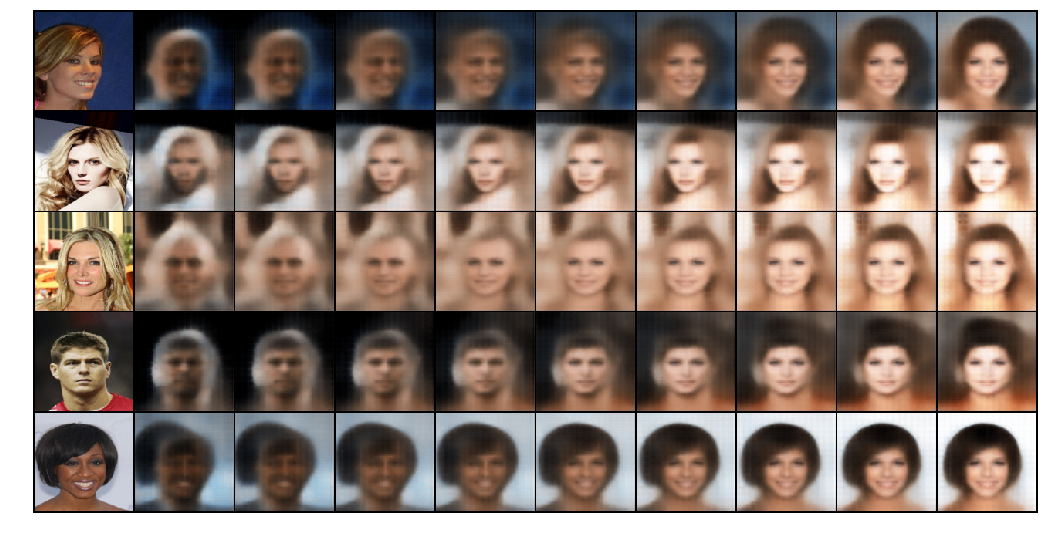

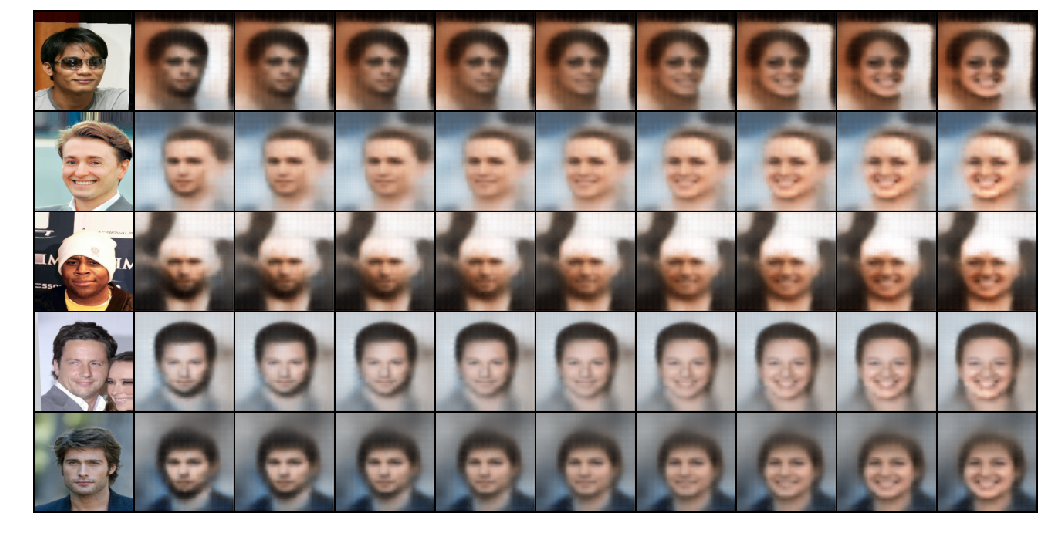

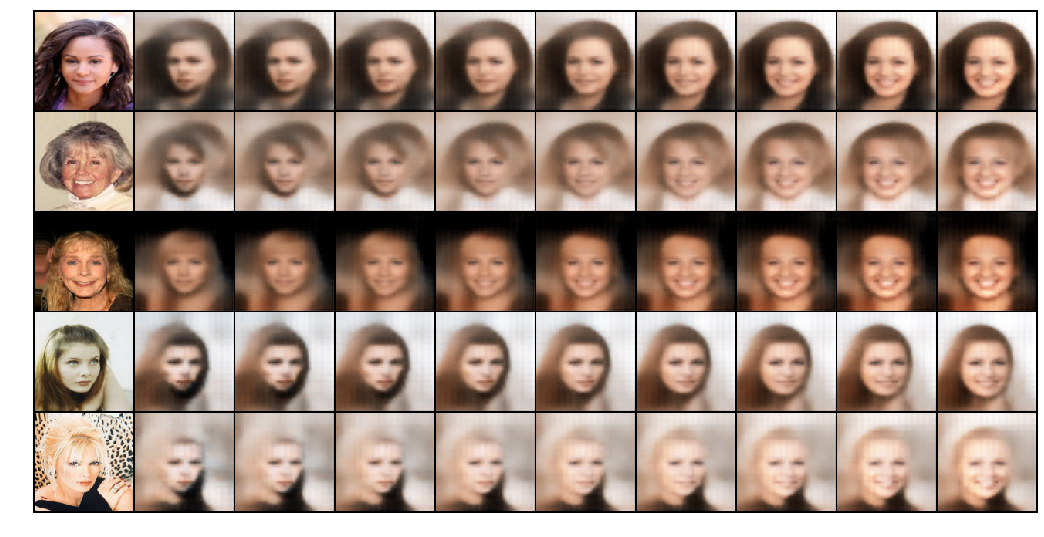

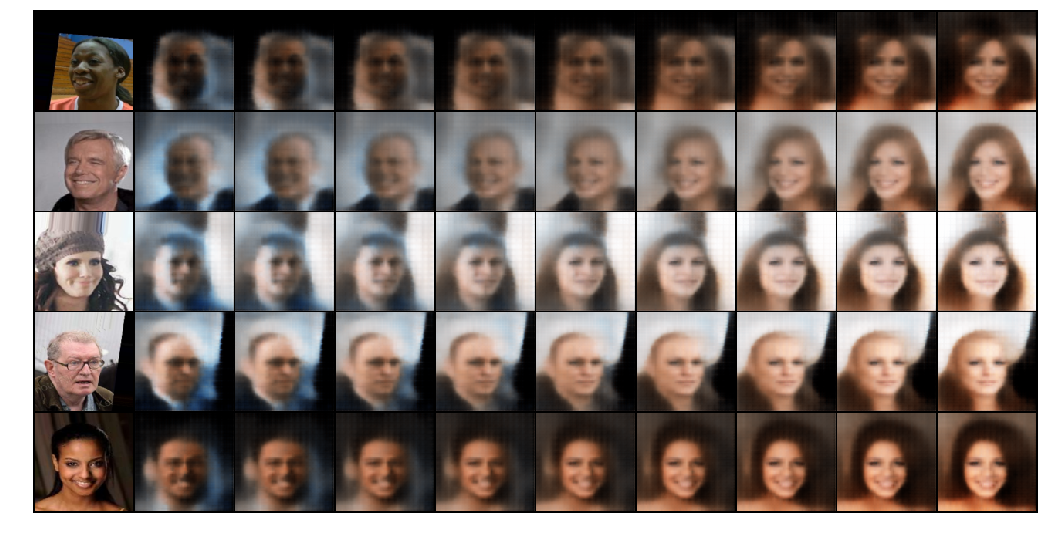

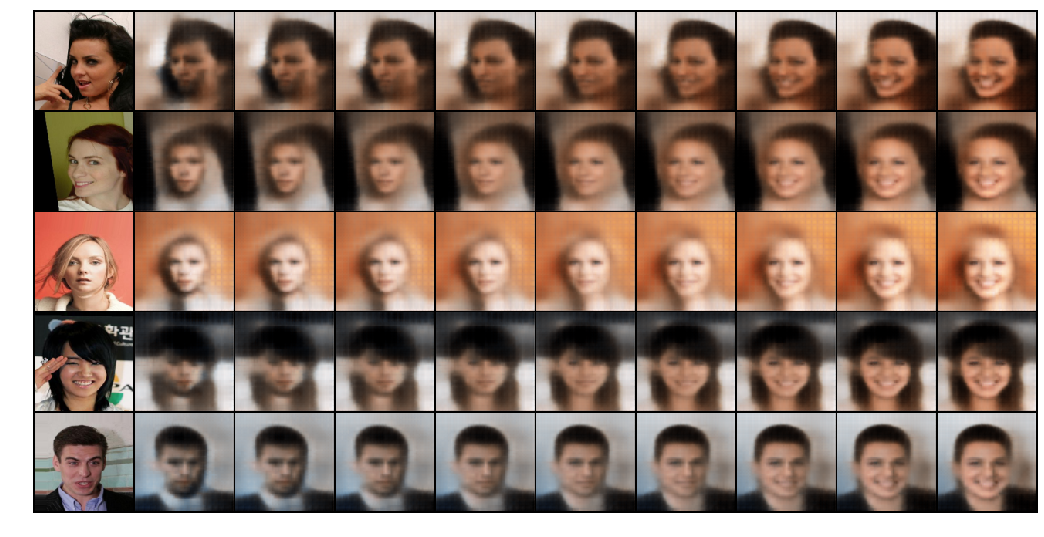

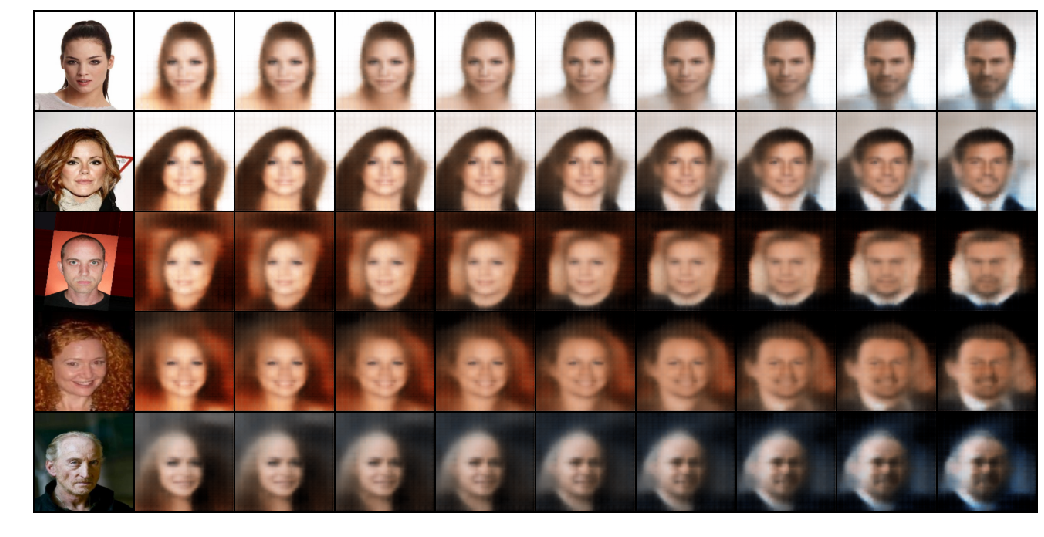

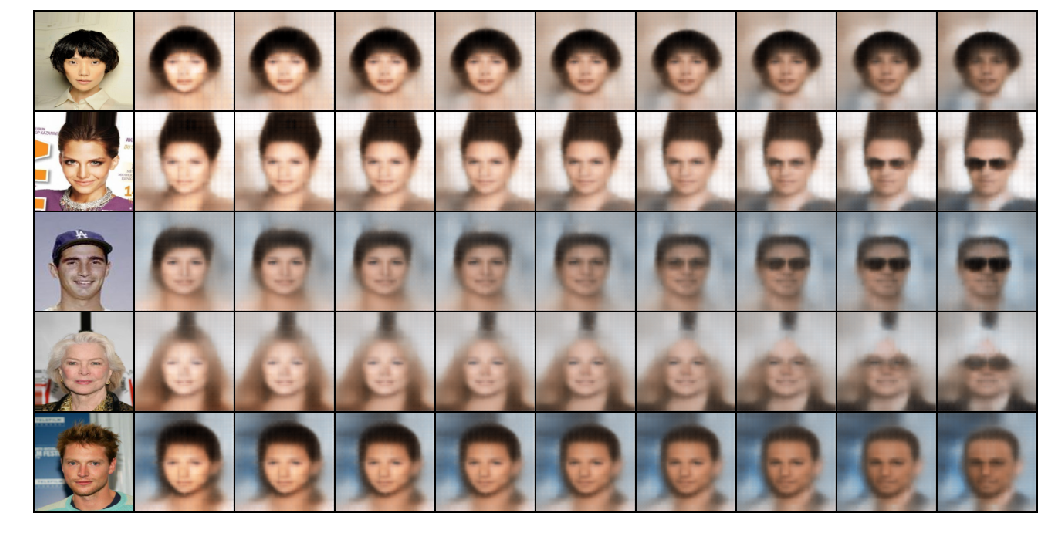

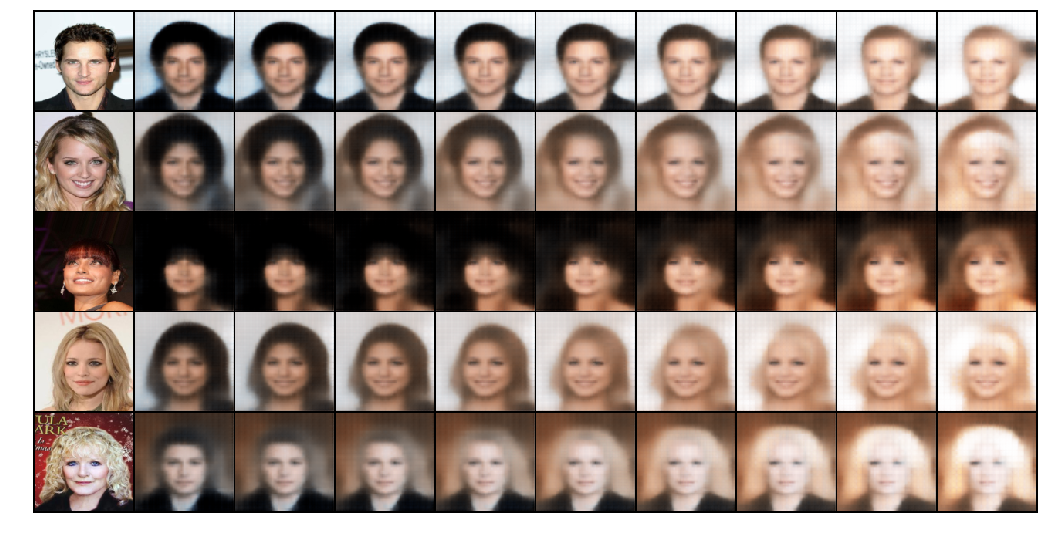

In [15]:
print('Attractive Vector')
add_vector_to_images('Attractive', attractive_vec)

print('Mouth Open Vector')
add_vector_to_images('Mouth_Open', mouth_open_vec)

print('Smiling Vector')
add_vector_to_images('Smiling', smiling_vec)

print('Lipstick Vector')
add_vector_to_images('Lipstick', lipstick_vec)

print('Young Vector')
add_vector_to_images('Young', young_vec)

print('Male Vector')
add_vector_to_images('Male', male_vec)

print('Eyeglasses Vector')
add_vector_to_images('Eyeglasses', eyeglasses_vec)

print('Blond Vector')
add_vector_to_images('Blond', blonde_vec)

In [18]:
def morph_faces(start_image_filename, end_image_filename):
    factors = np.arange(0, 1, 0.1)
    images = []
    
    start_image = PIL.Image.open(os.path.join(data_path, 'img_align_celeba_png', start_image_filename))
    end_image = PIL.Image.open(os.path.join(data_path, 'img_align_celeba_png', end_image_filename))
    
    start_image = transform(start_image)
    end_image = transform(end_image)
    
    inputs = torch.stack((start_image, end_image), 0).to(device)
    
    z_points, mu, log_var = model.encode(inputs)
    z_points = z_points.detach().cpu()
    
    images.append(start_image)
    for factor in factors:
        changed_z_point = z_points[0] * (1-factor) + z_points[1] * factor
        changed_image = model.decode(changed_z_point.to(device))[0]
        images.append(changed_image.detach().cpu())
        
    images.append(end_image)
        
    plt.figure(figsize=(18, 3))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images,
                                             nrow=12,
                                             padding=2,
                                             normalize=True), (1, 2, 0)))
    plt.savefig(os.path.join(image_save_folder, start_image_filename[:-4] + '_' + end_image_filename))
        

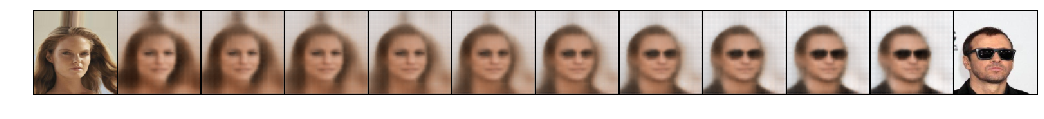

In [19]:
start_image_file = '000238.png'
end_image_file = '000193.png'

morph_faces(start_image_file, end_image_file)

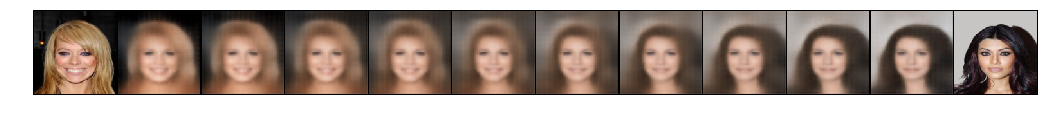

In [20]:
start_image_file = '000112.png'
end_image_file = '000258.png'

morph_faces(start_image_file, end_image_file)

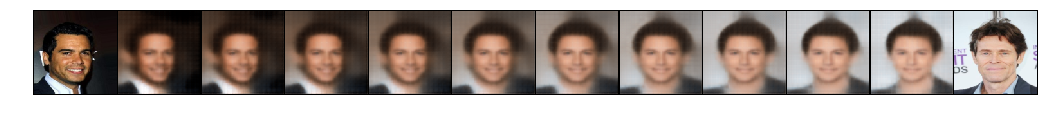

In [21]:
start_image_file = '000230.png'
end_image_file = '000712.png'


morph_faces(start_image_file, end_image_file)